In [1]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 4
GPU: Tesla V100-SXM2-32GB


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_pickle("../data/fd_vn_physical_with_tokens_and_pooled_output.pkl")

In [5]:
df.head()

,cc,sentence,syntax,fd,tokens,tokens_pt,tokens_ids,token_wise_output,pooled_output
0,"[{'text': 'cart', 'q_value': '+MER', 'index': ...",The grocery cart hit against the wall,Sbj V PathP,Autonomous Place,"[the, grocery, cart, hit, against, the, wall]","[[tensor(101), tensor(1996), tensor(13025), te...","[1996, 13025, 11122, 2718, 2114, 1996, 2813]","[[[tensor(-0.2603), tensor(0.5590), tensor(-0....","[[tensor(-0.8683), tensor(-0.2977), tensor(-0...."
1,"[{'text': 'type', 'q_value': '+MER', 'index': ...",That type of rope coiled easily around the post,Sbj V PathP,Autonomous Place,"[that, type, of, rope, coiled, easily, around,...","[[tensor(101), tensor(2008), tensor(2828), ten...","[2008, 2828, 1997, 8164, 24599, 4089, 2105, 19...","[[[tensor(-0.1397), tensor(-0.2141), tensor(0....","[[tensor(-0.7615), tensor(-0.0670), tensor(0.1..."
2,"[{'text': 'rope', 'q_value': '+MER', 'index': ...",The rope coiled around the post,Sbj V PathP,Autonomous Place,"[the, rope, coiled, around, the, post]","[[tensor(101), tensor(1996), tensor(8164), ten...","[1996, 8164, 24599, 2105, 1996, 2695]","[[[tensor(-0.0777), tensor(0.0408), tensor(0.1...","[[tensor(-0.6512), tensor(-0.0065), tensor(0.7..."
3,"[{'text': 'company', 'q_value': '+MER', 'index...",The company is wedging into new markets,Sbj V PathP,Autonomous Place,"[the, company, is, wed, ##ging, into, new, mar...","[[tensor(101), tensor(1996), tensor(2194), ten...","[1996, 2194, 2003, 21981, 4726, 2046, 2047, 6089]","[[[tensor(0.0615), tensor(0.1368), tensor(0.30...","[[tensor(-0.8246), tensor(-0.1659), tensor(0.2..."
4,"[{'text': 'computer', 'q_value': '+MER', 'inde...",The computer connected well to the network,Sbj V PathP,Autonomous Place,"[the, computer, connected, well, to, the, netw...","[[tensor(101), tensor(1996), tensor(3274), ten...","[1996, 3274, 4198, 2092, 2000, 1996, 2897]","[[[tensor(-0.0860), tensor(-0.0513), tensor(0....","[[tensor(-0.6017), tensor(-0.1227), tensor(0.6..."


In [6]:
_fd = df.fd.unique()
all_fd1 = []
all_fd2 = []
all_fd3 = []
for fd in _fd:
    all_fd1.append(fd.split()[0])
    all_fd2.append(fd.split()[1])
    if len(fd.split())>2:
        all_fd3.append(fd.split()[2])
all_fd1 = list(set(all_fd1))
all_fd2 = list(set(all_fd2))
all_fd3 = list(set(all_fd3))
print(all_fd1)
print(all_fd2)
print(all_fd3)

['Self-volitional', 'Instrument', 'Physical', 'Autonomous', 'Inducive', 'Volitional', 'Cause', 'Mutual']
['Force', 'Location', 'Deprive', 'Form', 'Manipulate', 'Constrain', 'Create', 'Place', 'Remove', 'DynamicTexture', 'Internal', 'Motion', 'COS', 'Provide']
['Purp', 'Affect', 'XPR']


In [7]:
all_items = []

#df1 = pd.DataFrame(columns=['sentence', 'Physical', 'Mutual', 'Self-volitional', 'Inducive', 'Volitional', 'Instrument', 'Autonomous', 'Cause', 'pooled_output'])
for idx, row in df.iterrows(): 
    sentence = row.sentence
    item = {"sentence":sentence, "features":[], "masks":[], 
        'Physical': 0, 'Mutual':0, 'Self-volitional':0, 'Inducive':0, 'Volitional':0, 'Instrument':0, 'Autonomous':0, 'Cause':0,
        'Internal': 0, 'Force': 0, 'Provide': 0, 'Constrain': 0, 'Form': 0, 'Manipulate': 0, 'Place': 0, 'Motion': 0, 'DynamicTexture': 0, 'Remove': 0, 'Create': 0, 'Location': 0, 'Deprive': 0, 'COS': 0,
        'XPR': 0, 'Purp': 0, 'Affect': 0}

    fd1 = row.fd.split()[0]
    fd2 = row.fd.split()[1]
    item[fd1] = 1
    item[fd2] = 1
    if len(fd.split())>2:
        fd3 = fd.split()[2]
        item[fd3] = 1
    all_items.append(item)

df1 = pd.DataFrame(all_items)

In [8]:
train, test = train_test_split(df1, test_size=0.1)
train = train.copy(deep=True)
test = test.copy(deep=True)

In [9]:
test.head()

,sentence,features,masks,Physical,Mutual,Self-volitional,Inducive,Volitional,Instrument,Autonomous,...,Motion,DynamicTexture,Remove,Create,Location,Deprive,COS,XPR,Purp,Affect
42,Jessica loaded boxes into the wagon,[],[],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
283,Carrie touched the cat,[],[],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
335,Gloria snoozed,[],[],0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
232,My wife had twins,[],[],0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
156,I kneaded the dough into a loaf,[],[],0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
train.head()

,sentence,features,masks,Physical,Mutual,Self-volitional,Inducive,Volitional,Instrument,Autonomous,...,Motion,DynamicTexture,Remove,Create,Location,Deprive,COS,XPR,Purp,Affect
106,The explosives destroyed the warehouse,[],[],1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
183,John took the radio apart.,[],[],0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
215,Martha carved a toy for the baby,[],[],0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
521,He skated Penny around the rink,[],[],0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
450,We avoided the area.,[],[],0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
train.shape

(504, 28)

In [12]:
test.shape

(56, 28)

In [13]:
df1.dtypes

sentence           object
features           object
masks              object
Physical            int64
Mutual              int64
Self-volitional     int64
Inducive            int64
Volitional          int64
Instrument          int64
Autonomous          int64
Cause               int64
Internal            int64
Force               int64
Provide             int64
Constrain           int64
Form                int64
Manipulate          int64
Place               int64
Motion              int64
DynamicTexture      int64
Remove              int64
Create              int64
Location            int64
Deprive             int64
COS                 int64
XPR                 int64
Purp                int64
Affect              int64
dtype: object

/nfs/student/r/regan/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


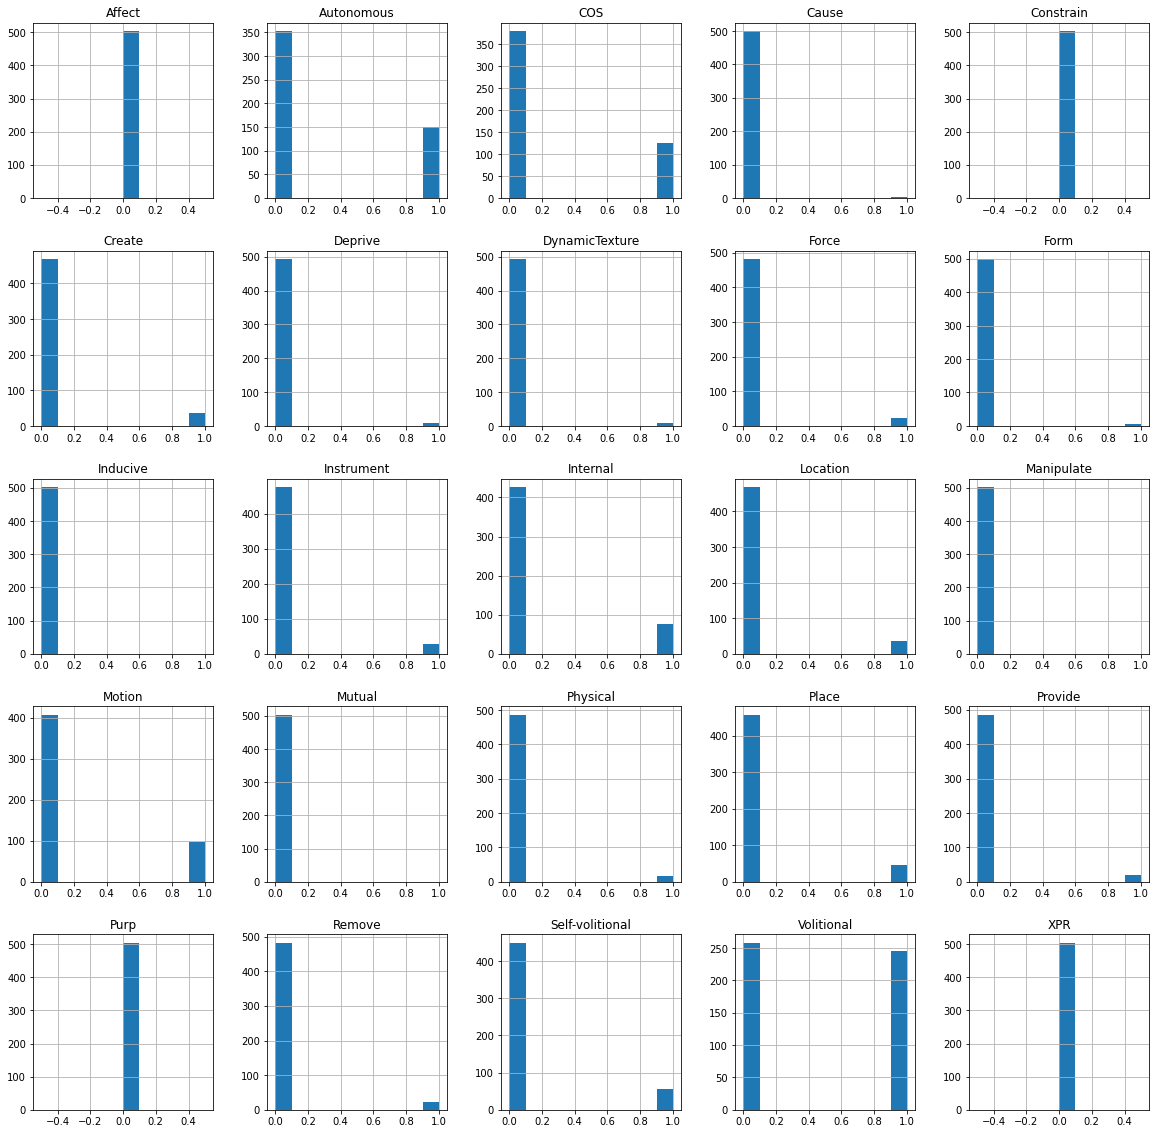

In [14]:
label_cols = ['Volitional', 'Physical', 'Cause', 'Inducive', 'Autonomous', 'Self-volitional', 'Mutual', 'Instrument', 'Provide', 'Location', 'Motion', 'Internal', 'Create', 'Constrain', 'Force', 'COS', 'DynamicTexture', 'Manipulate', 'Form', 'Place', 'Remove', 'Deprive', 'XPR', 'Affect', 'Purp']

fig, ax = plt.subplots(figsize=(20, 20));
train[label_cols].hist(ax=ax);

In [15]:
train.isnull().mean()

sentence           0.0
features           0.0
masks              0.0
Physical           0.0
Mutual             0.0
Self-volitional    0.0
Inducive           0.0
Volitional         0.0
Instrument         0.0
Autonomous         0.0
Cause              0.0
Internal           0.0
Force              0.0
Provide            0.0
Constrain          0.0
Form               0.0
Manipulate         0.0
Place              0.0
Motion             0.0
DynamicTexture     0.0
Remove             0.0
Create             0.0
Location           0.0
Deprive            0.0
COS                0.0
XPR                0.0
Purp               0.0
Affect             0.0
dtype: float64

In [15]:
test.isnull().mean()

sentence           0.0
features           0.0
masks              0.0
Physical           0.0
Mutual             0.0
Self-volitional    0.0
Inducive           0.0
Volitional         0.0
Instrument         0.0
Autonomous         0.0
Cause              0.0
Internal           0.0
Force              0.0
Provide            0.0
Constrain          0.0
Form               0.0
Manipulate         0.0
Place              0.0
Motion             0.0
DynamicTexture     0.0
Remove             0.0
Create             0.0
Location           0.0
Deprive            0.0
COS                0.0
XPR                0.0
Purp               0.0
Affect             0.0
dtype: float64

In [16]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [17]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [18]:
train_text_list = train["sentence"].values
test_text_list = test["sentence"].values

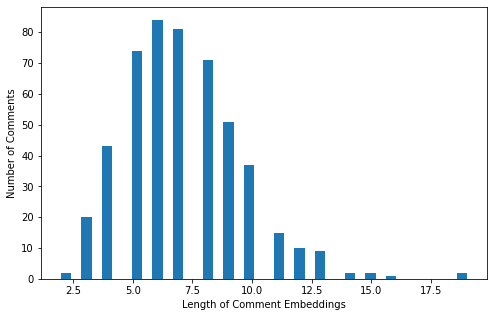

In [19]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

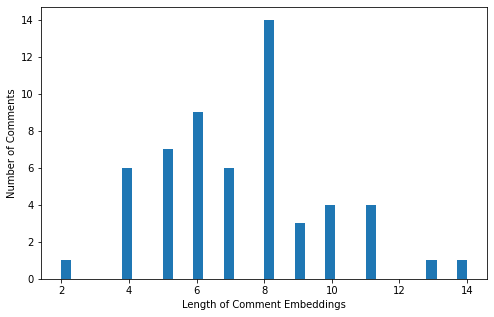

In [20]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [21]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [22]:
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=20)
train_input_ids.shape

(504, 20)

In [23]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=20)

In [24]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [25]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [26]:
train.head()

,sentence,features,masks,Physical,Mutual,Self-volitional,Inducive,Volitional,Instrument,Autonomous,...,Motion,DynamicTexture,Remove,Create,Location,Deprive,COS,XPR,Purp,Affect
106,The explosives destroyed the warehouse,"[18, 8983, 2946, 18, 9587, 4, 3, 0, 0, 0, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
183,John took the radio apart.,"[17, 22116, 288, 18, 1242, 3603, 9, 4, 3, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
215,Martha carved a toy for the baby,"[17, 1880, 7330, 11410, 24, 22, 117, 28, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
521,He skated Penny around the rink,"[43, 15906, 66, 17793, 199, 18, 17, 12771, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
450,We avoided the area.,"[80, 8759, 18, 290, 9, 4, 3, 0, 0, 0, 0, 0, 0,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
train["Volitional"].value_counts()

0    258
1    246
Name: Volitional, dtype: int64

In [28]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)
train = train.copy(deep=True)
valid = valid.copy(deep=True)

In [29]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ['Physical',
 'Mutual',
 'Self-volitional',
 'Inducive',
 'Volitional',
 'Instrument',
 'Autonomous',
 'Cause']
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [30]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [31]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [32]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [33]:
torch.cuda.empty_cache()

In [34]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))

In [35]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [36]:
num_epochs=5

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/nfs/research/regan/src/data/models/xlnet_fd_physical.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.01897006221208028
Valid loss: 0.010704038314300009


Epoch:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]

Saving model at epoch 0 with validation loss of 0.010704038314300009




Epoch:  40%|████      | 2/5 [00:06<00:13,  4.34s/it]

Train loss: 0.009119524516479549
Valid loss: 0.011254428341837213


Train loss: 0.008535348858785985
Valid loss: 0.010127312771164545


Epoch:  60%|██████    | 3/5 [00:12<00:09,  4.70s/it]

Saving model at epoch 2 with validation loss of 0.010127312771164545


Train loss: 0.008389846562747624
Valid loss: 0.008678975229216094


Epoch:  80%|████████  | 4/5 [00:17<00:04,  4.95s/it]

Saving model at epoch 3 with validation loss of 0.008678975229216094


Train loss: 0.00789946643057887
Valid loss: 0.00772105990955145


Epoch: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]

Saving model at epoch 4 with validation loss of 0.00772105990955145




Text(0.5, 1.0, 'Loss vs Number of Epochs')

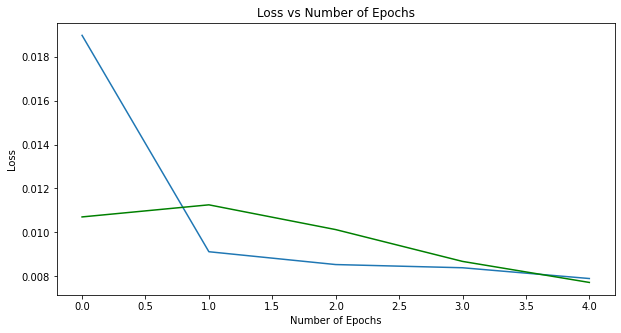

In [37]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [38]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [39]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[1.97362583e-02, 2.47807475e-03, 6.50191531e-02, 1.40458823e-03,
        7.36295342e-01, 1.39797091e-01, 8.99172053e-02, 1.20144803e-02],
       [1.97420772e-02, 2.47592200e-03, 6.50143698e-02, 1.40428788e-03,
        7.36255407e-01, 1.39859721e-01, 8.99643004e-02, 1.20012136e-02],
       [1.98308397e-02, 2.32229079e-03, 6.67812824e-02, 1.37730094e-03,
        7.31786132e-01, 1.35979205e-01, 9.28299874e-02, 1.15284482e-02],
       [3.06275841e-02, 5.82556240e-04, 1.06139362e-01, 1.18142879e-03,
        2.82522172e-01, 4.27523963e-02, 3.13175052e-01, 3.96021595e-03],
       [1.97424665e-02, 2.47718813e-03, 6.50165603e-02, 1.40447926e-03,
        7.36272216e-01, 1.39906481e-01, 8.99726152e-02, 1.20037431e-02],
       [2.09550858e-02, 2.03491864e-03, 6.89608455e-02, 1.36132399e-03,
        6.91129506e-01, 1.23876892e-01, 1.08126178e-01, 1.03985397e-02],
       [2.24068929e-02, 1.62847142e-03, 7.41177797e-02, 1.29299413e-03,
        6.37469888e-01, 1.08304188e-01, 1.28453344e-01, 8.

In [40]:


test["Physical"] = pred_probs[:,0]
test["Mutual"] = pred_probs[:,1]
test["Self-volitional"] = pred_probs[:,2]
test["Inducive"] = pred_probs[:,3]
test["Volitional"] = pred_probs[:,4]
test["Instrument"] = pred_probs[:,5]
test["Autonomous"] = pred_probs[:,6]
test["Cause"] = pred_probs[:,7]

In [ ]:
test

In [ ]:
np.round(pred_probs)